In [1]:
#meta: 10/5/2020 Framing ML
# Author: anya chaliotis anya@uw.edu
# sharing material from Andrew Ng's flagship ML course on Coursera, specifically Model Representation
# src: https://www.coursera.org/learn/machine-learning


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

import datetime #to track time

# Jeremy's Rollercoaster or How to Frame an ML Project

Outline  
1. Super simple example: Rollercoaster speed model  
2. What are we doing, why and how?  
3. ML framing
4. Back to Jeremy's Rollercoaster
5. Optional: One more example: 3 or 7? (aka is it a 3?)  
6. Challenge: MNIST Digits classifier ( 0 thru 9)

#### <TL;DR> 
Machine learning jargon and notations differ depending on the source.  Academia uses more mathy notations, Jeremy prefers to translate them into simpler terms. Simpler language sometimes results in confusion.  I.e, Loss function in academia is not the same as Loss function in fast.ai course.  But gradient descent process works the same way in both worlds.  I like how Andrew Ng organizes every (supervised) Machine Learning problem into 4 parts: model representation -> parameters -> cost function -> objective function.   It helps to keep track of what you're doing, why and how, so differences in terms won't slow down your learning.  

#### Read details if you have time
Start with Jeremy's super simple example in chapter 4, pg. 157

#### References
Andrew Ng's original Machine Learning course offered by Stanford https://www.coursera.org/learn/machine-learning

## 1. Super simple: Rollercoaster speed
### An End-to-End SGD Example


Can't be simpler
- one input variable: `time`
- one output variable: `speed`

Academia terms -> Univariate polynomial regresssion (in this case not linear regression because Jeremy uses a quadratic function).  
Tranlate to simple words -> Preditct speed based on time

Code below is a repeat of Jeremy's Rollercoaster example:

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

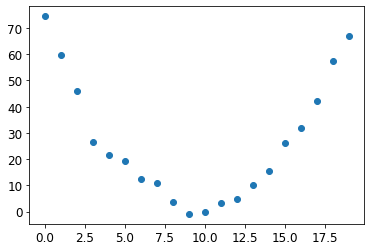

In [3]:
time = torch.arange(0,20).float(); time
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

### Anya change: Make it not random so I can calculate the parameters: a,b,c
Why do I need an exact function?  So I can see if my model training is any good...

speed = 0.75 * (time-9.5)^2 + 1  

My manual calculations (but somebody should check my math)  
speed = 0.75 * time^2 - 14.25 * time + 68.6875

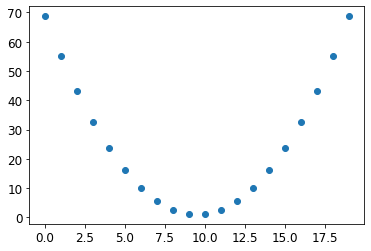

In [4]:
#$acchange
time = torch.arange(0,20).float(); time
#was speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed = 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [5]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use *mean squared error*:

In [6]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [7]:
#reproducibility $acchange
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

params = torch.randn(3).requires_grad_()

In [8]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

Next, we calculate the predictions:

In [9]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [10]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

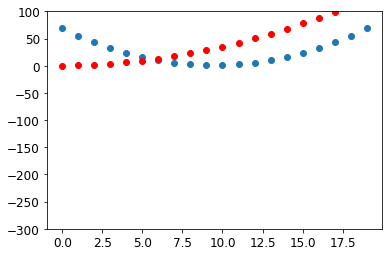

In [11]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

#### Step 3: Calculate the loss

We calculate the loss as follows:

In [12]:
loss = mse(preds, speed)
loss

tensor(1858.4668, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

#### Step 4: Calculate the gradients

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [13]:
loss.backward()
params.grad

tensor([11744.0742,   758.9104,    34.2038])

In [14]:
params.grad * 1e-5

tensor([0.1174, 0.0076, 0.0003])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [15]:
params

tensor([0.3367, 0.1288, 0.2345], requires_grad=True)

#### Step 5: Step the weights. 

Now we need to update the parameters based on the gradients we just calculated:

> a: Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

In [16]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Let's see if the loss has improved:

In [17]:
preds = f(time,params)
mse(preds, speed)

tensor(864.7213, grad_fn=<MeanBackward0>)

And take a look at the plot:

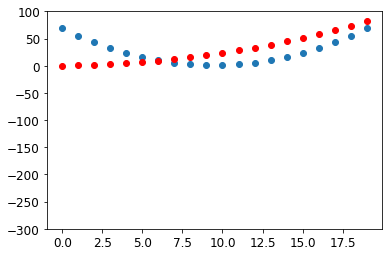

In [18]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [19]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [20]:
#$acchange - track time
start_time = datetime.datetime.now()

for i in range(10): apply_step(params)
    
#track time
print("Elapsed time", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

864.7213134765625
676.6717529296875
641.0843505859375
634.3472900390625
633.0697021484375
632.8255004882812
632.7764892578125
632.7645263671875
632.7596435546875
632.7561645507812
Elapsed time 2020-10-06 11:08:28


In [21]:
#$acchange - view parameters after 10 iterations
params

tensor([0.1289, 0.1149, 0.2355], requires_grad=True)

In [22]:
#hide
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

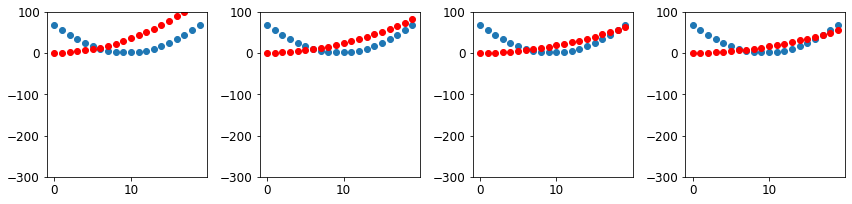

In [23]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

### Summarizing Gradient Descent

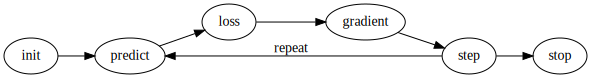

In [24]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## 2. What are we doing, why and how?  

So this is a supervised learning problem.  
More formally, our goal is, given a dataset, to learn a function h: x -> y so that h(x) is a good predictor of y. 

Terms: function `h` is for hypothesis.  

![Process](myImages/supervised_learning.png)

## 3. ML Framing - Univariate Linear Regression

![ML framing](myImages/ml_framework.png)

## 3a. ML Framing for Rollercoaster Model - Univariate Quadratic Regression

### Hypothesis: 
#### $$ h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_1^2$$

### Parameters: 
#### $$\theta_0, \theta_1, \theta_2$$


### Cost function:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

### Objective function: 
Find the best possible line  
#### minimize $$ J(\theta_0, \theta_1, \theta_2)$$


More terms from Andrew Ng :

### Loss function:  
#### $$ h_\theta(x^{(i)}) - y^{(i)}$$
$$prediction - actual$$ 
- computes the error for a single training example (always same number as number of data points)
- embedded into Cost function J which measures how well we're doing on the entire dataset (always just one value)





With each step of gradient descent, parameters $\theta_0, \theta_1, \theta_2$ come closer to the optimal values that will achieve the lowest cost J($\theta$).

## Translated to Jeremy's language: Rollercoaster Model

### Hypothesis -> Model: 
#### $$ f =  a*t^2 + b*t + c$$

### Parameters -> Parameters consisting of weights & bias: 
#### $$a, b, c$$

### Cost function -> Loss function:
$$ mse = (preds - targets)^2.mean() $$

### Objective function -> Just words that we want to find best parameters: 
#### minimize $$mse$$




### How? In both worlds, using Gradient Descent algorithm

Jeremy's formulation:  
- We want to find a function that matches our observations  
- Can't consider every possible function, so (by looking at the shape of data) make a guess it's quadratic  
- Quadratic function has a form: `𝑎 ∗ 𝑡^2 + 𝑏 ∗ 𝑡 + 𝑐`
- To find the best quadratic function, we need to find only the best values for a, b, and c.
- Perform 7 steps:
![7 Steps](myImages/7steps.png)
    1. initialize parameters  (3 parameters)
    2. calculate predictions  (20 predictions)
    3. calculate loss - chose to use MSE -> loss for each data point, squared, and then averaged for the entire dataset (1 scalar number)  
    our goal is to find the lowest loss  
    4. how: by using GD algorithm -> calculate gradients (3 gradients)  
    5. update parameters (3 parameters) based on calculated gradients (3 gradients)  
    6. back to step 2...
    7. stop after loss is small enough or after max number of iterations (if the loss started to increase, choose a smaller learning rate)  
    


## 4. Back to Jeremy's Rollercoaster
- play with lr and n of iterations  
- show parameters found after n iterations
- see if parameters get closer to the calculated params

In [25]:
#modified to stop when good enough
def apply_step1(params, prn=True, view_loss=212.):
    preds = f(time, params)
    loss = mse(preds, speed)
    
    if loss > 0.020:        
        ## Step 4: Calculate the gradients
        loss.backward()
        ## Step 5: adjust step 
        params.data -= lr * params.grad.data
        params.grad = None
    else:
        #print("good enough")
        return
    
    if prn and loss < view_loss: print(loss.item())
    return preds

In [26]:
#modify plotting function
def show_preds_closer(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed, alpha = 0.7)
    ax.scatter(time, to_np(preds), color='red', alpha = 0.6, marker='^' )
    ax.set_ylim(-10,100)

#### Take 1. Try to get a smaller loss and see if model fits better

In [27]:
#reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#play with learning rate
lr = 0.00003529
params = torch.randn(3).requires_grad_()

#track time
start_time = datetime.datetime.now()

n_loop = 60000
for i in range(n_loop): 
    p = apply_step1(params, view_loss=211.65) 
    #if not p == None: print(p)

print("Elapsed time", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


211.64804077148438
211.6442108154297
211.6403350830078
211.63650512695312
211.6326141357422
211.6287841796875
211.62484741210938
211.62100219726562
211.61709594726562
211.61328125
211.6093292236328
Elapsed time 2020-10-06 11:08:43


In [28]:
#check out best params?
print(params, sep='\n')

tensor([ 0.3943, -5.9970, 29.0886], requires_grad=True)


##### Compare real model to fitted model 
speed = 0.75 * time^2 - 14.25 * time + 68.6875

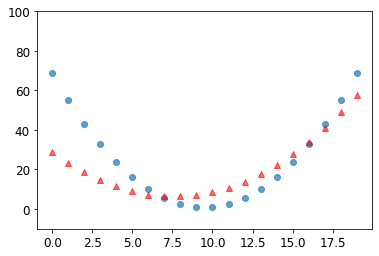

In [29]:
#plot
my_preds = f(time, params)
show_preds_closer(my_preds)

#### Take 2. Try to get a smaller loss and see if model fits better

In [30]:
#reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#play with learning rate
lr = 0.00003529
params = torch.randn(3).requires_grad_()

#track time
start_time = datetime.datetime.now()

n_loop = 190000
for i in range(n_loop): 
    p = apply_step1(params, view_loss=19.725) 
    #if not p == None: print(p)

print("Elapsed time", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


19.724821090698242
19.724454879760742
19.72410011291504
19.723731994628906
Elapsed time 2020-10-06 11:09:28


##### Compare real model to fitted model - getting closer and closer!
speed = 0.75 * time^2 - 14.25 * time + 68.6875

In [31]:
#check out best params?
print(params, sep='\n')

tensor([  0.6414, -11.7304,  56.5979], requires_grad=True)


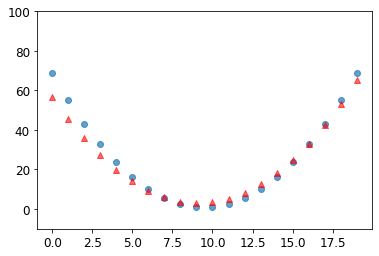

In [32]:
#plot
my_preds = f(time, params)
show_preds_closer(my_preds)

## 4. One more example: 3 or 7? 
Also known as: is it a 3? 

## In Jeremy's language only
Check out Andrew Ng's course for his formulation - he does an amazing job.  Much better than me here...

### Hypothesis -> Model: 
#### $$ f =  sigmoid(x@weights + bias)$$

### Parameters -> Parameters consisting of weights & bias: 
#### $$weights + bias$$  
weights is tensor `x` (28 * 28) per image  
1 bias per image  
784 + 1 parameters to fit!

### Cost function -> Loss function:
$$ torch.where(targets==1, 1-predictions, predictions).mean() $$
not mse, not rmse

### Objective function -> Just words that we want to find best parameters: 
#### minimize $$loss$$


I hope this helps.